# Text Summarization

In [48]:
DEMO_DATA_ROOT = "../../../RepositoryData/data"

- Efficient ways to summarize the semantics of massive collections of documents
- Three general methods:
    - Keyphrase extraction
    - Topic modeling
    - Document summarization

## Keyphrase Extraction

- N-grams
- Collocations

In [1]:
from nltk.corpus import gutenberg
import text_normalizer as tn
import nltk
from operator import itemgetter

Loading corpus, Alice in the Wonderland.

In [2]:
# load corpus
alice = gutenberg.sents(fileids='carroll-alice.txt')
# concatenate each word token of a sentence
alice = [' '.join(ts) for ts in alice]
# normalize text
# `filter()` removes tokens that are False after normalization
norm_alice = list(filter(None, 
                         tn.normalize_corpus(alice, text_lemmatization=False))) 

Compare raw texts vs, noramlized texts:

In [3]:
print(alice[0], '\n', norm_alice[0])

[ Alice ' s Adventures in Wonderland by Lewis Carroll 1865 ] 
 alice adventures wonderland lewis carroll


### N-grams

A function to create n-grams.

In [4]:
def compute_ngrams(sequence, n):
    return list(
        zip(*(sequence[index:]
               for index in range(n)))
    )

In [5]:
compute_ngrams(['A','B','C','D'],2)

[('A', 'B'), ('B', 'C'), ('C', 'D')]

In [6]:
def flatten_corpus(corpus):
    return ' '.join([document.strip() 
                     for document in corpus])

In [7]:
def get_top_ngrams(corpus, ngram_val=1, limit=5):
    
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)

    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), 
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq) 
                     for text, freq in sorted_ngrams]

    return sorted_ngrams

In [8]:
get_top_ngrams(corpus=norm_alice, ngram_val=2,
               limit=10)

[('said alice', 123),
 ('mock turtle', 56),
 ('march hare', 31),
 ('said king', 29),
 ('thought alice', 26),
 ('white rabbit', 22),
 ('said hatter', 22),
 ('said mock', 20),
 ('said caterpillar', 18),
 ('said gryphon', 18)]

In [9]:
get_top_ngrams(corpus=norm_alice, ngram_val=3,
               limit=10)

[('said mock turtle', 20),
 ('said march hare', 10),
 ('poor little thing', 6),
 ('little golden key', 5),
 ('certainly said alice', 5),
 ('white kid gloves', 5),
 ('march hare said', 5),
 ('mock turtle said', 5),
 ('know said alice', 4),
 ('might well say', 4)]

### Collocations (Bigrams)

In [143]:
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

finder = BigramCollocationFinder.from_documents([item.split() 
                                                for item 
                                                in norm_alice])
finder

Apply frequency filter:

In [144]:
finder.apply_freq_filter(5)

In [145]:
## Inherit BigramAssocMeasures
class AugmentedBigramAssocMeasures(BigramAssocMeasures):
    @classmethod
    def dp_fwd(cls, *marginals):
        """Scores bigrams using delta P forward, the normalized 
        conditional prob of w2 given w1: p(w2/w1)-p(w2/_w1)
        This may be shown with respect to a contingency table::

                w1    ~w1
             ------ ------
         w2 | n_ii | n_oi | = n_xi
             ------ ------
        ~w2 | n_io | n_oo |
             ------ ------
             = n_ix        TOTAL = n_xx
        """
        
        n_ii, n_oi, n_io, n_oo  = cls._contingency(*marginals)

        return (n_ii/(n_ii+n_io)) - (n_oi/(n_oi+n_oo))

    @classmethod
    def dp_bwd(cls, *marginals):
        """Scores bigrams using delta P forward, the normalized 
        conditional prob of w1 given w2: p(w1/w2)-p(w1/_w2)
        This may be shown with respect to a contingency table::

                w1    ~w1
             ------ ------
         w2 | n_ii | n_oi | = n_xi
             ------ ------
        ~w2 | n_io | n_oo |
             ------ ------
             = n_ix        TOTAL = n_xx
        """
        
        n_ii, n_oi, n_io, n_oo  = cls._contingency(*marginals)

        return (n_ii/(n_ii+n_oi)) - (n_io/(n_io+n_oo))

Collocations based on raw frequencies:

In [146]:
bigram_measures = AugmentedBigramAssocMeasures()                                                
finder.nbest(bigram_measures.raw_freq, 10)

[('said', 'alice'),
 ('mock', 'turtle'),
 ('march', 'hare'),
 ('said', 'king'),
 ('thought', 'alice'),
 ('said', 'hatter'),
 ('white', 'rabbit'),
 ('said', 'mock'),
 ('said', 'caterpillar'),
 ('said', 'gryphon')]

Collocations based on PMI:

In [129]:
finder.nbest(bigram_measures.pmi, 10)


[('accustomed', 'usurpation', 'conquest'),
 ('adjourn', 'immediate', 'adoption'),
 ('adoption', 'energetic', 'remedies'),
 ('ancient', 'modern', 'seaography'),
 ('apple', 'roast', 'turkey'),
 ('arithmetic', 'ambition', 'distraction'),
 ('brother', 'latin', 'grammar'),
 ('canvas', 'bag', 'tied'),
 ('cherry', 'tart', 'custard'),
 ('circle', 'exact', 'shape')]

In [141]:
bigrams_pmi=finder.score_ngrams(bigram_measures.pmi)
bigrams_pmi[:10]

[(('soo', 'oop'), 10.771961015522411),
 (('beg', 'pardon'), 10.579315937580013),
 (('bread', 'butter'), 10.186998514801253),
 (('golden', 'key'), 10.186998514801253),
 (('kid', 'gloves'), 10.119884318942718),
 (('twinkle', 'twinkle'), 9.901244032467378),
 (('evening', 'beautiful'), 9.878876219438924),
 (('join', 'dance'), 9.878876219438924),
 (('play', 'croquet'), 9.731319031025066),
 (('set', 'work'), 9.356923516243567)]

In [147]:
bigrams_dpfwd=finder.score_ngrams(bigram_measures.dp_fwd)
bigrams_dpfwd[:10]

[(('soo', 'oop'), 1.0),
 (('beg', 'pardon'), 0.9998365211705085),
 (('march', 'hare'), 0.9997542796297814),
 (('white', 'kid'), 0.9979566816510013),
 (('mock', 'turtle'), 0.9491525423728814),
 (('set', 'work'), 0.749345977763244),
 (('three', 'gardeners'), 0.7482014388489209),
 (('little', 'golden'), 0.7042309444009763),
 (('join', 'dance'), 0.6923076923076923),
 (('bread', 'butter'), 0.6665849072030087)]

In [43]:
bigrams_dpbwd=finder.score_ngrams(bigram_measures.dp_bwd)
bigrams_dpbwd[:10]

[(('soo', 'oop'), 1.0),
 (('mock', 'turtle'), 0.9997537754432042),
 (('join', 'dance'), 0.9996729621453683),
 (('kid', 'gloves'), 0.9995096035962403),
 (('evening', 'beautiful'), 0.9993461381283204),
 (('march', 'hare'), 0.9117647058823529),
 (('bread', 'butter'), 0.8568976188529854),
 (('golden', 'key'), 0.8568976188529854),
 (('trembling', 'voice'), 0.8298185384992643),
 (('beg', 'pardon'), 0.75)]

### Collocations (N-grams)

In [45]:
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures

finder = TrigramCollocationFinder.from_documents([item.split() 
                                                for item 
                                                in norm_alice])

Trigrams based on raw frequencies:

In [46]:

trigram_measures = TrigramAssocMeasures()                                                
finder.nbest(trigram_measures.raw_freq, 10)

[('said', 'mock', 'turtle'),
 ('said', 'march', 'hare'),
 ('poor', 'little', 'thing'),
 ('little', 'golden', 'key'),
 ('march', 'hare', 'said'),
 ('mock', 'turtle', 'said'),
 ('white', 'kid', 'gloves'),
 ('beau', 'ootiful', 'soo'),
 ('certainly', 'said', 'alice'),
 ('might', 'well', 'say')]

Trigrams based on PMI:

In [47]:
finder.nbest(trigram_measures.pmi, 10)


[('accustomed', 'usurpation', 'conquest'),
 ('adjourn', 'immediate', 'adoption'),
 ('adoption', 'energetic', 'remedies'),
 ('ancient', 'modern', 'seaography'),
 ('apple', 'roast', 'turkey'),
 ('arithmetic', 'ambition', 'distraction'),
 ('brother', 'latin', 'grammar'),
 ('canvas', 'bag', 'tied'),
 ('cherry', 'tart', 'custard'),
 ('circle', 'exact', 'shape')]

## Weighted Tag-based Phrase Extraction

- Chunks

Load data.

In [50]:
data = open(DEMO_DATA_ROOT+'/elephants.txt', 'r+').readlines()
sentences = nltk.sent_tokenize(data[0])
len(sentences)

29

Normalize texts.

In [51]:
norm_sentences = tn.normalize_corpus(sentences, text_lower_case=False, 
                                     text_stemming=False, text_lemmatization=False, stopword_removal=False)
norm_sentences[:3]

['Elephants are large mammals of the family Elephantidae and the order Proboscidea',
 'Three species are currently recognised the African bush elephant Loxodonta africana the African forest elephant L cyclotis and the Asian elephant Elephas maximus',
 'Elephants are scattered throughout subSaharan Africa South Asia and Southeast Asia']

Define chunk-based tokenizer.

In [52]:
import itertools
stopwords = nltk.corpus.stopwords.words('english')

def get_chunks(sentences, grammar = r'NP: {<DT>? <JJ>* <NN.*>+}', stopword_list=stopwords):
    
    all_chunks = []
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    
    for sentence in sentences:
        
        tagged_sents = [nltk.pos_tag(nltk.word_tokenize(sentence))]   
        
        chunks = [chunker.parse(tagged_sent) 
                      for tagged_sent in tagged_sents]
        
        wtc_sents = [nltk.chunk.tree2conlltags(chunk)
                         for chunk in chunks]    
        
        flattened_chunks = list(
                            itertools.chain.from_iterable(
                                wtc_sent for wtc_sent in wtc_sents)
                           )
        
        valid_chunks_tagged = [(status, [wtc for wtc in chunk]) 
                                   for status, chunk 
                                       in itertools.groupby(flattened_chunks, 
                                                lambda word_pos_chunk: word_pos_chunk[2] != 'O')]
        
        valid_chunks = [' '.join(word.lower() 
                                for word, tag, chunk in wtc_group 
                                    if word.lower() not in stopword_list) 
                                        for status, wtc_group in valid_chunks_tagged
                                            if status]
                                            
        all_chunks.append(valid_chunks)
    
    return all_chunks

Get chunks from texts.

In [53]:
chunks = get_chunks(norm_sentences)
chunks

[['elephants', 'large mammals', 'family elephantidae', 'order proboscidea'],
 ['species',
  'african bush elephant loxodonta',
  'african forest elephant l cyclotis',
  'asian elephant elephas maximus'],
 ['elephants', 'subsaharan africa south asia', 'southeast asia'],
 ['elephantidae',
  'family',
  'order proboscidea',
  'extinct members',
  'order',
  'deinotheres gomphotheres mammoths',
  'mastodons'],
 ['elephants',
  'several distinctive features',
  'long trunk',
  'proboscis',
  'many purposes',
  'water',
  'grasping objects'],
 ['incisors', 'tusks', 'weapons', 'tools', 'objects'],
 ['elephants', 'flaps', 'body temperature'],
 ['pillarlike legs', 'great weight'],
 ['african elephants',
  'ears',
  'backs',
  'asian elephants',
  'ears',
  'convex',
  'level backs'],
 ['elephants', 'different habitats', 'savannahs forests deserts', 'marshes'],
 ['water'],
 ['keystone species', 'impact', 'environments'],
 ['animals',
  'distance',
  'elephants',
  'predators',
  'lions tigers hy

Weight chunks.

In [54]:
from gensim import corpora, models

def get_tfidf_weighted_keyphrases(sentences, 
                                  grammar=r'NP: {<DT>? <JJ>* <NN.*>+}',
                                  top_n=10):
    
    valid_chunks = get_chunks(sentences, grammar=grammar)
                                     
    dictionary = corpora.Dictionary(valid_chunks)
    corpus = [dictionary.doc2bow(chunk) for chunk in valid_chunks]
    
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    weighted_phrases = {dictionary.get(idx): value 
                           for doc in corpus_tfidf 
                               for idx, value in doc}
                            
    weighted_phrases = sorted(weighted_phrases.items(), 
                              key=itemgetter(1), reverse=True)
    weighted_phrases = [(term, round(wt, 3)) for term, wt in weighted_phrases]
    
    return weighted_phrases[:top_n]

In [55]:
get_tfidf_weighted_keyphrases(sentences=norm_sentences, top_n=30)

[('water', 1.0),
 ('asia', 0.807),
 ('wild', 0.764),
 ('great weight', 0.707),
 ('pillarlike legs', 0.707),
 ('southeast asia', 0.693),
 ('subsaharan africa south asia', 0.693),
 ('body temperature', 0.693),
 ('flaps', 0.693),
 ('fissionfusion society', 0.693),
 ('multiple family groups', 0.693),
 ('art folklore religion literature', 0.693),
 ('popular culture', 0.693),
 ('ears', 0.681),
 ('males', 0.653),
 ('males bulls', 0.653),
 ('family elephantidae', 0.607),
 ('large mammals', 0.607),
 ('years', 0.607),
 ('environments', 0.577),
 ('impact', 0.577),
 ('keystone species', 0.577),
 ('cetaceans', 0.577),
 ('elephant intelligence', 0.577),
 ('primates', 0.577),
 ('dead individuals', 0.577),
 ('kind', 0.577),
 ('selfawareness', 0.577),
 ('different habitats', 0.57),
 ('marshes', 0.57)]

In [57]:
from gensim.summarization import keywords

key_words = keywords(data[0], ratio=1.0, scores=True, lemmatize=True)
[(item, round(score, 3)) for item, score in key_words][:25]

[('african bush elephant', 0.261),
 ('including', 0.141),
 ('family', 0.137),
 ('cow', 0.124),
 ('forests', 0.108),
 ('female', 0.103),
 ('asia', 0.102),
 ('objects', 0.098),
 ('sight', 0.098),
 ('ivory', 0.098),
 ('tigers', 0.098),
 ('males', 0.088),
 ('folklore', 0.087),
 ('religion', 0.087),
 ('known', 0.087),
 ('larger ears', 0.085),
 ('water', 0.075),
 ('highly recognisable', 0.075),
 ('breathing lifting', 0.074),
 ('flaps', 0.073),
 ('africa', 0.072),
 ('gomphotheres', 0.072),
 ('animals tend', 0.071),
 ('success', 0.071),
 ('south', 0.07)]

## Topic Modeling

Download corpus and unzip the corpus files.

In [59]:
#!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2020-10-10 11:45:38--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu... 128.122.49.30
Connecting to cs.nyu.edu|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  2.69MB/s    in 5.9s    

2020-10-10 11:45:45 (2.07 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



In [64]:
#!tar -xzf nips12raw_str602.tgz

### Load  Data

In [65]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

['RAW_DATA_NOTES', 'idx', 'nips12', 'nips09', 'nips00', 'nips07', 'nips06', 'nips01', 'nips08', 'README_yann', 'MATLAB_NOTES', 'nips11', 'nips10', 'nips04', 'nips03', 'nips02', 'nips05', 'orig']


1740

In [66]:
print(papers[0][:100])


775 
A NEURAL-NETWORK SOLUTION TO THE CONCENTRATOR 
ASSIGNMENT PROBLEM 
Gene A. Tagliarini 
Edward W


### Preprocess Data

In [67]:
%%time
import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 38.1 s, sys: 271 ms, total: 38.4 s
Wall time: 39.4 s


## Feature Enginerring

In [68]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['neural_network', 'solution', 'concentrator', 'assignment', 'problem', 'gene', 'tagliarini', 'edward', 'page', 'department_computer', 'science', 'clemson', 'university', 'clemson', 'sc', 'abstract', 'network', 'simple', 'analog', 'processor', 'neuron', 'like', 'property', 'employed', 'compute', 'good', 'solution', 'variety', 'optimization', 'prob_lem', 'paper_present', 'neural_net', 'solution', 'resource', 'allocation', 'prob_lem', 'arises', 'providing', 'local', 'access', 'backbone', 'wide', 'area', 'com', 'munication', 'network', 'problem', 'described', 'term', 'energy']


In [69]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, 'able'), (1, 'abstract'), (2, 'acad_sci'), (3, 'access'), (4, 'accommodated'), (5, 'actu'), (6, 'actually'), (7, 'added'), (8, 'additionally'), (9, 'algebraic'), (10, 'algo_rithm'), (11, 'allocation'), (12, 'allow'), (13, 'allows'), (14, 'ally')]
Total Vocabulary Size: 78892


In [70]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


In [71]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(2, 1), (10, 1), (13, 1), (15, 1), (16, 1), (19, 1), (20, 1), (33, 3), (39, 6), (40, 1), (56, 1), (57, 1), (66, 1), (71, 1), (75, 1), (77, 4), (79, 1), (89, 2), (93, 2), (102, 2), (105, 3), (111, 1), (112, 6), (114, 2), (115, 1), (117, 1), (127, 9), (128, 1), (134, 2), (143, 1), (147, 1), (149, 7), (151, 2), (152, 4), (157, 1), (158, 1), (159, 3), (163, 1), (164, 1), (166, 2), (170, 1), (181, 2), (182, 3), (183, 2), (187, 5), (189, 3), (190, 1), (193, 2), (203, 2), (210, 1)]


In [72]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('acad_sci', 1), ('allow', 1), ('although', 1), ('american_institute', 1), ('among', 1), ('another', 1), ('appropriate', 1), ('assume', 3), ('capacity', 6), ('cause', 1), ('comparison', 1), ('complete', 1), ('connection', 1), ('consider', 1), ('construction', 1), ('convergence', 4), ('corresponding', 1), ('defined', 2), ('detail', 2), ('either', 2), ('energy', 3), ('equal', 1), ('equation', 6), ('even', 2), ('exactly', 1), ('except', 1), ('field', 9), ('fig', 1), ('follows', 2), ('global_minimum', 1), ('guarantee', 1), ('high', 7), ('hop_field', 2), ('hopfield', 4), ('i2', 1), ('ieee_trans', 1), ('ii', 3), ('implement', 1), ('implemented', 1), ('include', 2), ('individual', 1), ('le', 2), ('least', 3), ('like', 2), ('local_minimum', 5), ('location', 3), ('low', 1), ('made', 2), ('minimum', 2), ('necessary', 1)]


In [73]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


### Topic Models with Latent Semantic Indexing (LSI)

In [74]:
TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

In [75]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
0.487*"neuron" + 0.396*"cell" + -0.257*"state" + 0.191*"response" + -0.187*"training" + 0.170*"stimulus" + 0.117*"activity" + -0.109*"class" + 0.099*"spike" + 0.097*"pattern" + 0.096*"circuit" + 0.096*"synaptic" + -0.095*"vector" + 0.090*"signal" + 0.090*"firing" + 0.088*"visual" + -0.084*"classifier" + -0.083*"action" + -0.078*"word" + 0.078*"cortical"

Topic #3:
-0.627*"state" + 0.395*"image" + -0.219*"neuron" + 0.209*"feature" + -0.188*"action" + 0.137*"unit" + 0.131*"object" + -0.130*"control" + 0.129*"training" + -0.109*"policy" + 0.103*"classifier" + 0.090*"class" + -0.081*"step" + -0.081*"dynamic" + 0.080*"classifica

In [76]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('neuron', 0.487), ('cell', 0.396), ('response', 0.191), ('stimulus', 0.17), ('activity', 0.117), ('spike', 0.099), ('pattern', 0.097), ('circuit', 0.096), ('synaptic', 0.096), ('signal', 0.09), ('firing', 0.09), ('visual', 0.088), ('cortical', 0.078)]
--------------------------------------------------
Direction 2: [('state', -0.257), ('training', -0.187), ('class', -0.109), ('vector', -0.095), ('classifier', -0.084), ('action', -0.083), ('w

In [77]:
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [78]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.019,0.026,-0.029,-0.012,0.022,-0.047,0.005,-0.020,0.011,0.002
1,0.016,0.004,-0.012,-0.001,0.007,-0.015,0.012,-0.007,-0.003,-0.002
2,0.019,-0.003,0.014,0.032,0.011,-0.002,-0.011,-0.041,-0.029,0.016
3,0.021,0.028,-0.004,-0.003,-0.003,0.000,-0.008,0.009,0.008,0.014
4,0.032,-0.011,0.007,0.030,-0.015,-0.018,0.042,-0.015,0.004,-0.017
5,0.032,-0.009,-0.022,0.026,0.001,-0.018,0.038,-0.015,0.007,0.002
6,0.012,0.005,-0.009,-0.008,0.014,-0.006,0.012,0.006,0.006,0.002
7,0.040,-0.001,0.058,-0.073,-0.051,-0.038,0.037,-0.031,0.015,-0.034
8,0.015,0.023,-0.010,0.005,0.010,-0.013,0.001,-0.005,-0.004,-0.004
9,0.023,0.040,-0.017,-0.007,-0.019,0.065,-0.024,0.007,-0.022,-0.001


In [79]:
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T6', 'T9', 'T2']
Paper Summary:
564 
PROGRAMMABLE SYNAPTIC CHIP FOR 
ELECTRONIC NEURAL NETWORKS 
A. Moopenn, H. Langenbacher, A.P. Thakoor, and S.K. Khanna 
Jet Propulsion Laboratory 
California Institute of Technology 
Pasadena, CA 91009 
ABSTRACT 
A binary synaptic matrix chip has been developed for electronic 
neural networks. The matrix chip contains a programmable 32X32 
array of "long channel" NMOSFET binary connection elements imple- 
mented in a 3-um bulk CMOS process. Since the neurons are kept off- 
chip, the synapti

Document #250:
Dominant Topics (top 3): ['T8', 'T1', 'T5']
Paper Summary:
308 Donnett and Smithers 
Neuronal Group Selection Theory: 
A Grounding in Robotics 
Jim Donnett nd Tim Smithers 
Department of Artificial Intelligence 
University of Edinburgh 
5 Forrest Hill 
Edinburgh EH1 2QL 
S COTLAND 
ABSTRACT 
In this paper, we discuss a current attempt at applying the organi- 
zational principle Edelman calls Neuronal Group

### Topic Models with Latent Dirichlet Allocation (LDA)

In [80]:
%%time
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 3min 3s, sys: 1.88 s, total: 3min 5s
Wall time: 3min 6s


In [81]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.008*"noise" + 0.008*"linear" + 0.008*"solution" + 0.008*"vector" + 0.008*"equation" + 0.006*"matrix" + 0.005*"training" + 0.005*"rule" + 0.004*"optimal" + 0.004*"signal" + 0.004*"eq" + 0.004*"distribution" + 0.004*"component" + 0.004*"filter" + 0.004*"line" + 0.004*"local" + 0.004*"rate" + 0.004*"average" + 0.004*"surface" + 0.004*"ica"

Topic #2:
0.009*"vector" + 0.007*"let" + 0.006*"theorem" + 0.006*"class" + 0.006*"bound" + 0.006*"node" + 0.005*"threshold" + 0.005*"linear" + 0.005*"matrix" + 0.005*"size" + 0.004*"proof" + 0.004*"complexity" + 0.004*"consider" + 0.004*"polynomial" + 0.004*"unit" + 0.004*"bit" + 0.004*"layer" + 0.004*"defined" + 0.004*"probability" + 0.003*"approximation"

Topic #3:
0.033*"state" + 0.010*"action" + 0.008*"step" + 0.007*"control" + 0.006*"policy" + 0.006*"task" + 0.005*"reinforcement_learning" + 0.005*"optimal" + 0.004*"convergence" + 0.004*"rate" + 0.004*"stochastic" + 0.004*"sequence" + 0.004*"environment" + 0.003*"dynamic" + 0.003*"trans

In [82]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0446050148659014


In [83]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('vector', 0.009), ('let', 0.007), ('theorem', 0.006), ('class', 0.006), ('bound', 0.006), ('node', 0.006), ('threshold', 0.005), ('linear', 0.005), ('matrix', 0.005), ('size', 0.005), ('proof', 0.004), ('complexity', 0.004), ('consider', 0.004), ('polynomial', 0.004), ('unit', 0.004), ('bit', 0.004), ('layer', 0.004), ('defined', 0.004), ('probability', 0.004), ('approximation', 0.003)]

Topic #2:
[('unit', 0.026), ('cell', 0.012), ('pattern', 0.012), ('stimulus', 0.009), ('layer', 0.009), ('response', 0.008), ('activity', 0.008), ('representation', 0.006), ('activation', 0.006), ('connection', 0.005), ('neuron', 0.005), ('visual', 0.005), ('hidden_unit', 0.004), ('motion', 0.004), ('structure', 0.004), ('direction', 0.004), ('receptive_field', 0.004), ('task', 0.003), ('simulation', 0.003), ('training', 0.003)]

Topic #3:
[('neuron', 0.024), ('cell', 0.009), ('circuit', 0.007), ('signal', 0.006), ('current', 0.006), ('synaptic', 0.005), ('spike', 0.

In [84]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['vector', 'let', 'theorem', 'class', 'bound', 'node', 'threshold', 'linear', 'matrix', 'size', 'proof', 'complexity', 'consider', 'polynomial', 'unit', 'bit', 'layer', 'defined', 'probability', 'approximation']

Topic #2:
['unit', 'cell', 'pattern', 'stimulus', 'layer', 'response', 'activity', 'representation', 'activation', 'connection', 'neuron', 'visual', 'hidden_unit', 'motion', 'structure', 'direction', 'receptive_field', 'task', 'simulation', 'training']

Topic #3:
['neuron', 'cell', 'circuit', 'signal', 'current', 'synaptic', 'spike', 'response', 'neural', 'pattern', 'voltage', 'dynamic', 'activity', 'noise', 'chip', 'synapsis', 'state', 'frequency', 'effect', 'connection']

Topic #4:
['training', 'word', 'recognition', 'vector', 'unit', 'speech', 'trained', 'layer', 'net', 'architecture', 'classification', 'feature', 'hmm', 'task', 'pattern', 'class', 'classifier', 'sequence', 'speaker', 'experiment']

Topic #5:
['rule', 'node', 'pattern', 

In [85]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.4603294946568357
Avg. Coherence Score (UMass): -1.0446050148659014
Model Perplexity: -7.800904216105166


### LDA with Mallet

In [90]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-10-10 12:08:45--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu... 128.119.246.70
Connecting to mallet.cs.umass.edu|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  4.00MB/s    in 3.9s    

2020-10-10 12:08:50 (4.00 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [91]:
!unzip -q mallet-2.0.8.zip

In [92]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=16)

In [93]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_mallet.show_topic(n, topn=20)] 
                   for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'pattern', 'signal', 'spike', 'effect', 'frequency', 'neural', 'synaptic', 'cortical', 'firing', 'connection', 'et_al', 'brain', 'temporal', 'cortex', 'change']

Topic #2:
['search', 'experiment', 'cluster', 'feature', 'technique', 'graph', 'measure', 'size', 'cost', 'clustering', 'test', 'run', 'local', 'random', 'solution', 'table', 'region', 'distance', 'average', 'instance']

Topic #3:
['image', 'object', 'feature', 'visual', 'motion', 'position', 'direction', 'pixel', 'map', 'location', 'field', 'representation', 'region', 'view', 'target', 'face', 'filter', 'human', 'local', 'subject']

Topic #4:
['class', 'bound', 'size', 'probability', 'theorem', 'tree', 'node', 'theory', 'linear', 'threshold', 'complexity', 'defined', 'constant', 'approximation', 'loss', 'proof', 'hypothesis', 'polynomial', 'machine', 'distribution']

Topic #5:
['unit', 'pattern', 'layer', 'training', 'hidden_unit', 'rule', 'net', 'architecture',

In [94]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5038963843699132
Avg. Coherence Score (UMass): -1.0285099132611792
Model Perplexity: -8.53533


### LDA Tuning - Finading Optimal Number of Topics

In [95]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [96]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=16)

100%|██████████| 29/29 [51:04<00:00, 105.66s/it]


In [97]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
18,20,0.5475
17,19,0.5438
23,25,0.5425
22,24,0.5411
26,28,0.5410
24,26,0.5410
16,18,0.5401
21,23,0.5375
28,30,0.5338
27,29,0.5331


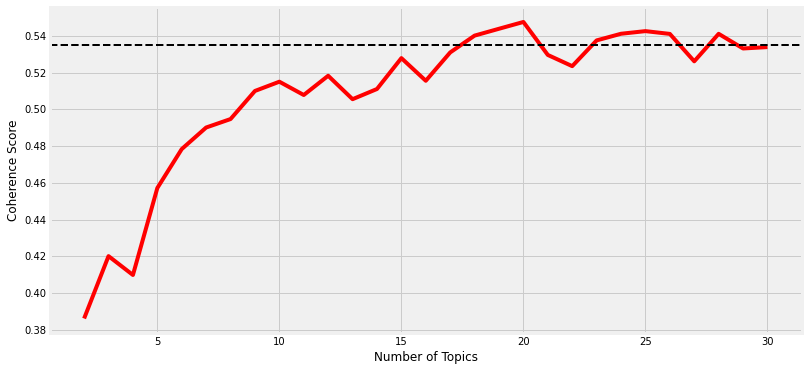

In [98]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [99]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

In [100]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['word', 'recognition', 'training', 'speech', 'context', 'hmm', 'sequence', 'state', 'speaker', 'frame', 'letter', 'speech_recognition', 'phoneme', 'mlp', 'feature', 'experiment', 'vowel', 'trained', 'hybrid', 'segmentation']

Topic #2:
['classification', 'class', 'classifier', 'feature', 'pattern', 'training', 'character', 'face', 'test', 'training_set', 'recognition', 'digit', 'distance', 'database', 'sample', 'error_rate', 'rate', 'size', 'nearest_neighbor', 'trained']

Topic #3:
['training', 'prediction', 'test', 'training_set', 'experiment', 'selection', 'trained', 'table', 'regression', 'average', 'query', 'measure', 'cross_validation', 'technique', 'time_series', 'application', 'expert', 'rbf', 'test_set', 'bias']

Topic #4:
['neuron', 'cell', 'spike', 'synaptic', 'activity', 'response', 'firing', 'stimulus', 'pattern', 'synapsis', 'effect', 'threshold', 'neural', 'et_al', 'neuronal', 'inhibitory', 'simulation', 'firing_rate', 'excitatory', 'current']

Topic #5:
['stat

In [101]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,word,classification,training,neuron,state,rule,vector,distribution,solution,memory,noise,motion,variable,bound,dynamic,unit,node,circuit,image,signal
Term2,recognition,class,prediction,cell,control,representation,matrix,probability,convergence,bit,equation,visual,mixture,class,state,layer,sequence,chip,object,filter
Term3,training,classifier,test,spike,action,task,linear,estimate,gradient,pattern,curve,response,cluster,theorem,phase,hidden_unit,tree,current,feature,frequency
Term4,speech,feature,training_set,synaptic,policy,human,nonlinear,prior,constraint,code,correlation,stimulus,clustering,approximation,module,net,graph,analog,pixel,source
Term5,context,pattern,experiment,activity,step,structure,dimensional,gaussian,equation,capacity,average,cell,step,proof,behavior,training,structure,voltage,view,channel
Term6,hmm,training,selection,response,controller,feature,mapping,sample,rate,neuron,eq,map,component,polynomial,recurrent,pattern,state,neuron,region,noise
Term7,sequence,character,trained,firing,environment,similarity,dimension,density,iteration,element,rate,direction,em,loss,attractor,architecture,symbol,design,surface,response
Term8,state,face,table,stimulus,reinforcement_learning,search,transformation,bayesian,optimization,processor,theory,receptive_field,expert,linear,feedback,activation,string,implementation,shape,component
Term9,speaker,test,regression,pattern,task,subject,component,estimation,energy,size,limit,activity,hidden,complexity,trajectory,trained,path,device,visual,temporal
Term10,frame,training_set,average,synapsis,robot,instance,local,variance,minimum,vector,solution,spatial,likelihood,xi,neural,hidden_layer,length,synapse,scale,sound


In [102]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/Users/Alvin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"word, recognition, training, speech, context, hmm, sequence, state, speaker, frame, letter, speech_recognition, phoneme, mlp, feature, experiment, vowel, trained, hybrid, segmentation"
Topic2,"classification, class, classifier, feature, pattern, training, character, face, test, training_set, recognition, digit, distance, database, sample, error_rate, rate, size, nearest_neighbor, trained"
Topic3,"training, prediction, test, training_set, experiment, selection, trained, table, regression, average, query, measure, cross_validation, technique, time_series, application, expert, rbf, test_set, bias"
Topic4,"neuron, cell, spike, synaptic, activity, response, firing, stimulus, pattern, synapsis, effect, threshold, neural, et_al, neuronal, inhibitory, simulation, firing_rate, excitatory, current"
Topic5,"state, control, action, policy, step, controller, environment, reinforcement_learning, task, robot, trajectory, optimal, goal, reward, change, td, agent, trial, position, current"
Topic6,"rule, representation, task, human, structure, feature, similarity, search, subject, instance, learned, knowledge, connectionist, domain, role, level, theory, category, position, note"
Topic7,"vector, matrix, linear, nonlinear, dimensional, mapping, dimension, transformation, component, local, map, operator, distance, basis, pca, structure, rule, projection, inverse, principal_component"
Topic8,"distribution, probability, estimate, prior, gaussian, sample, density, bayesian, estimation, variance, log, approximation, estimator, entropy, posterior, kernel, noise, true, stochastic, statistic"
Topic9,"solution, convergence, gradient, constraint, equation, rate, iteration, optimization, energy, minimum, update, optimal, gradient_descent, constant, derivative, cost, step, quadratic, find, local_minimum"
Topic10,"memory, bit, pattern, code, capacity, neuron, element, processor, size, vector, parallel, hopfield, computation, stored, connection, operation, neural_net, coding, binary, computer"


### Interpreting Topic Model Results


In [103]:
tm_results = best_lda_model[bow_corpus]


In [104]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(8, 0.2286752707313455),
 (9, 0.219922860109776),
 (16, 0.20199731453507883),
 (11, 0.22351903724452743),
 (15, 0.448782535684299)]

In [105]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

Dominant topics distribution across corpus.

In [112]:
# pd.set_option('display.max_colwidth', 200)
# topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
#                                                 'Dominant Topic': {
#                                                     'Doc Count': np.size,
#                                                     '% Total Docs': np.size }
#                                               })
# topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
# topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(lambda row: round((row*100) / len(papers), 2))
# topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
# topic_stats_df

Dominant topics in specific papers

In [107]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,4,27.44,"neuron, cell, spike, synaptic, activity, response, firing, stimulus, pattern, synapsis, effect, threshold, neural, et_al, neuronal, inhibitory, simulation, firing_rate, excitatory, current","367 \nSCHEMA FOR MOTOR CONTROL \nUTILIZING A NETWORK MODEL OF THE CEREBELLUM \nJames C. Houk, Ph.D. \nNorthwestern University Medical School, Chicago, Illinois \n60201 \nABSTRACT \nThis paper outl..."
13,13,18,67.04,"circuit, chip, current, analog, voltage, neuron, design, implementation, device, synapse, digital, neural, pulse, transistor, array, gain, line, analog_vlsi, hardware, implemented","564 \nPROGRAMMABLE SYNAPTIC CHIP FOR \nELECTRONIC NEURAL NETWORKS \nA. Moopenn, H. Langenbacher, A.P. Thakoor, and S.K. Khanna \nJet Propulsion Laboratory \nCalifornia Institute of Technology \nPa..."
17,17,16,18.68,"unit, layer, hidden_unit, net, training, pattern, architecture, activation, trained, hidden_layer, back_propagation, connection, task, hidden, learn, simulation, backpropagation, target, epoch, step","348 \nMinkowski-r Back-Propagation: Learning in Connectionist \nModels with Non-Euclidian Error Signals \nStephen Jos6 Hanson and David J. Burr \nBell Communications Research \nMorristown, New Jer..."
392,392,5,40.82,"state, control, action, policy, step, controller, environment, reinforcement_learning, task, robot, trajectory, optimal, goal, reward, change, td, agent, trial, position, current",Learning Trajectory and Force Control \nof an Artificial Muscle Arm \nby Parallel-hierarchical Neural Network Model \nMasazumi Katayama Mitsuo Kawato \nCognitive Processes Department \nATR Auditor...
503,503,14,77.50,"bound, class, theorem, approximation, proof, polynomial, loss, linear, complexity, xi, theory, threshold, defined, constant, size, condition, hypothesis, bounded, definition, assume","Polynomial Uniform Convergence of \nRelative Frequencies to Probabilities \nAlberto Bertoni, Paola Campadelll;' Anna Morpurgo, Sandra Panlzza \nDipartimento di Scienze dell'Informazione \nUniversi..."
681,681,18,40.43,"circuit, chip, current, analog, voltage, neuron, design, implementation, device, synapse, digital, neural, pulse, transistor, array, gain, line, analog_vlsi, hardware, implemented","Visual Motion Computation in Analog \nVLSI using Pulses \nRahul Sarpeshkar, Wyeth Bair and Christof Koch \nComputation and Neural Systems Program \nCalifornia Institute of Technology \nPasadena, C..."
733,733,4,28.12,"neuron, cell, spike, synaptic, activity, response, firing, stimulus, pattern, synapsis, effect, threshold, neural, et_al, neuronal, inhibitory, simulation, firing_rate, excitatory, current","Foraging in an Uncertain Environment Using \nPredictive Hebbian Learning \nP. Read Montague ; Peter Dayan, and Terrence J. Sejnowski \nComputational Neurobiology Lab, The Salk Institute, \n10010 ..."
906,906,19,35.45,"image, object, feature, pixel, view, region, surface, shape, visual, scale, local, contour, part, edge, representation, location, position, scene, vision, matching","Correlation and Interpolation Networks for \nReal-time Expression Analysis/Synthesis. \nTrevor Darrell, Irfan Essa, Alex Pentland \nPerceptual Computing Group \nMIT Media Lab \nAbstract \nWe descr..."
996,996,15,38.69,"dynamic, state, phase, module, behavior, recurrent, attractor, feedback, trajectory, neural, control, delay, equation, oscillation, fixed_point, oscillator, connection, motor, stable, stability","Dynamics of Attention as Near \nSaddle-Node Bifurcation Behavior \nHiroyuki Nakahara* \nGeneral Systems Studies \nUniversity of Tokyo \n3-8-1 Komaba, Meguro \nTokyo 153, Japan \nn akahar a@vermeer..."
1622,1622,8,37.00,"distribution, probability, estimate, prior, gaussian, sample, density, bayesian, estimation, variance, log, approximation, estimator, entropy, posterior, kernel, noise, true, stochastic, statistic","Probabilistic methods for Support Vector \nMachines \nPeter Sollich \nDepartment of Mathemati

Relevant papers per topic based on dominance.

In [114]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda 
                                                topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)))

Document  Dominant Topic  Contribution %  \
Dominant Topic                                                  
1              1135      1135               1           71.51   
               635        635               1           71.48   
               532        532               1           68.61   
               612        612               1           66.65   
               651        651               1           64.78   
...                       ...             ...             ...   
20             1284      1284              20           18.90   
               312        312              20           16.67   
               567        567              20           16.53   
               158        158              20           14.95   
               257        257              20           13.29   

                                                                                                                                                                                                  Topic Desc  \
Dominant Topic                                                                                                                                                                                                 
1              1135  word, recognition, training, speech, context, hmm, sequence, state, speaker, frame, letter, speech_recognition, phoneme, mlp, feature, experiment, vowel, trained, hybrid, segmentation   
               635   word, recognition, training, speech, context, hmm, sequence, state, speaker, frame, letter, speech_recognition, phoneme, mlp, feature, experiment, vowel, trained, hybrid, segmentation   
               532   word, recognition, training, speech, context, hmm, sequence, state, speaker, frame, letter, speech_recognition, phoneme, mlp, feature, experiment, vowel, trained, hybrid, segmentation   
               612   word, recognition, training, speech, context, hmm, sequence, state, speaker, frame, letter, speech_recognition, phoneme, mlp, feature, experiment, vowel, trained, hybrid, segmentation   
               651   word, recognition, training, speech, context, hmm, sequence, state, speaker, frame, letter, speech_recognition, phoneme, mlp, feature, experiment, vowel, trained, hybrid, segmentation   
...                                                                                                                                                                                                      ...   
20             1284        signal, filter, frequency, source, channel, noise, response, component, temporal, sound, auditory, ica, amplitude, phase, adaptation, detection, change, eeg, processing, subject   
               312         signal, filter, frequency, source, channel, noise, response, component, temporal, sound, auditory, ica, amplitude, phase, adaptation, detection, change, eeg, processing, subject   
               567         signal, filter, frequency, source, channel, noise, response, component, temporal, sound, auditory, ica, amplitude, phase, adaptation, detection, change, eeg, processing, subject   
               158         signal, filter, frequency, source, channel, noise, response, component, temporal, sound, auditory, ica, amplitude, phase, adaptation, detection, change, eeg, processing, subject   
               257         signal, filter, frequency, source, channel, noise, response, component, temporal, sound, auditory, ica, amplitude, phase, adaptation, detection, change, eeg, processing, subject   

                                                                                                                                                                                                                       Paper  
Dominant Topic                                                                                                                                                                                                                
1              1135  Con

### Predicting Topics for New Paper

In [119]:
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('test_data/nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
              
print('Total New Papers:', len(new_papers))

Total New Papers: 4


In [120]:
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

In [121]:
print(norm_new_papers[0][:30])


['cooperative', 'graphical_model', 'josip', 'djolonga', 'dept_computer', 'science', 'eth', 'zurich', 'josipd', 'inf', 'ethz', 'ch', 'stefanie', 'jegelka', 'csail', 'mit', 'stefje', 'mit_edu', 'sebastian', 'tschiatschek', 'dept_computer', 'science', 'eth', 'zurich', 'stschia', 'inf', 'ethz', 'ch', 'andreas', 'krause']


In [122]:
print(norm_bow_features[0][:30])

[(0, 1), (1, 1), (5, 1), (11, 1), (13, 1), (14, 1), (30, 1), (31, 2), (33, 4), (34, 1), (41, 3), (43, 1), (50, 1), (51, 1), (53, 1), (56, 1), (57, 2), (58, 1), (59, 6), (62, 1), (73, 7), (76, 1), (77, 4), (79, 2), (80, 1), (81, 2), (82, 2), (84, 3), (89, 5), (92, 1)]


In [123]:
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics

In [124]:
topic_preds = get_topic_predictions(topic_model=best_lda_model, 
                                    corpus=norm_bow_features, topn=2)
topic_preds

[[(13, 0.212), (12, 0.207)],
 [(4, 0.393), (13, 0.219)],
 [(18, 0.263), (3, 0.136)],
 [(0, 0.265), (5, 0.177)]]

In [125]:
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in 
                                        [[round(wt*100, 2) 
                                              for topic_num, wt in item] 
                                                 for item in topic_preds] 
                                    for topic_wt in topic_list]

results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]

In [126]:
pd.set_option('display.max_colwidth', 300)
results_df

,Dominant Topics,Contribution %,Topic Desc,Paper Desc
Papers,,,,
1,14,21.2,"bound, class, theorem, approximation, proof, polynomial, loss, linear, complexity, xi, theory, threshold, defined, constant, size, condition, hypothesis, bounded, definition, assume","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
1,13,20.7,"variable, mixture, cluster, clustering, step, component, em, expert, hidden, likelihood, structure, mean_field, approximation, probability, em_algorithm, missing, mi, xi, log_likelihood, binary","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
2,5,39.3,"state, control, action, policy, step, controller, environment, reinforcement_learning, task, robot, trajectory, optimal, goal, reward, change, td, agent, trial, position, current","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
2,14,21.9,"bound, class, theorem, approximation, proof, polynomial, loss, linear, complexity, xi, theory, threshold, defined, constant, size, condition, hypothesis, bounded, definition, assume","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
3,19,26.3,"image, object, feature, pixel, view, region, surface, shape, visual, scale, local, contour, part, edge, representation, location, position, scene, vision, matching","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
3,4,13.6,"neuron, cell, spike, synaptic, activity, response, firing, stimulus, pattern, synapsis, effect, threshold, neural, et_al, neuronal, inhibitory, simulation, firing_rate, excitatory, current","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
4,1,26.5,"word, recognition, training, speech, context, hmm, sequence, state, speaker, frame, letter, speech_recognition, phoneme, mlp, feature, experiment, vowel, trained, hybrid, segmentation","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"
4,6,17.7,"rule, representation, task, human, structure, feature, similarity, search, subject, instance, learned, knowledge, connectionist, domain, role, level, theory, category, position, note","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"


## Document Summarization

## References

- Text Analytics with Python (2nd Ed.) Chapter 6